In [14]:
# load features from mat files
import os
import numpy as np
import scipy.io as sio

AudioVisual_path = '../data/cavmae_av_embeddings.mat'
data = sio.loadmat(AudioVisual_path)['audiovisual_embeddings']
data.shape


(3655, 768)

In [16]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from feature_extraction.cav_mae_extractor import initialize_model, get_audio_duration, extract_av_embeddings
import scipy.io
y, sr, duration = get_audio_duration("../rest_audio.wav")
model = initialize_model()
embeddings = extract_av_embeddings(y, sr, duration, model)

scipy.io.savemat("../data/cavmae_av_embeddings.mat", {"audiovisual_embeddings": embeddings})


A CAV-MAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
Missing keys: [] 
Unexpected keys: []


 27%|██████████▋                            | 1003/3655 [00:53<02:19, 19.06it/s]

Processed 1000 / 3655 seconds


 55%|█████████████████████▎                 | 2003/3655 [01:46<01:27, 18.92it/s]

Processed 2000 / 3655 seconds


 82%|████████████████████████████████       | 3003/3655 [02:38<00:34, 18.93it/s]

Processed 3000 / 3655 seconds


100%|███████████████████████████████████████| 3655/3655 [03:13<00:00, 18.91it/s]

Final embeddings shape: (3655, 768)


In [17]:
#brain data
LH_path = '../notmean_left_Meanfile.mat'
RH_path = '../notmean_right_Meanfile.mat'

data_LH = sio.loadmat(LH_path)['Left_data']
data_RH = sio.loadmat(RH_path)['Right_data']

data_RH.shape, data_LH.shape

((32492, 3655), (32492, 3655))

In [18]:
brain = np.concatenate((data_LH, data_RH), axis=0)
brain = brain.transpose()

print('Brain data dimensions:', brain.shape)


Brain data dimensions: (3655, 64984)


In [19]:

def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / (std + 1e-8) 
    print(f"std.min = {std.min()}, std.max = {std.max()}")
    if std.any() == 0:
        print("Warning: Standard deviation is zero for some features, normalization may not be effective.")
    return normalized_data

data = normalize_data(data)
brain = normalize_data(brain)

std.min = 0.0, std.max = 0.9184421300888062
std.min = 0.0, std.max = 1.3306655238461678


In [20]:
window_length = 10

def create_training_data(data, activity, window_length):
    time = data.shape[0]

    x = []
    y = []

    for i in range(time - window_length):
        window = data[i:i + window_length, :]
        x.append(window.reshape(-1))
        y.append(activity[i + window_length - 1])

    return x, y

In [21]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from feature_extraction.cav_mae_extractor import initialize_model, get_audio_duration

sys.path.append('./cav-mae/src')
model = initialize_model()
duration = get_audio_duration("../rest_audio.wav")


A CAV-MAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
Missing keys: [] 
Unexpected keys: []


In [22]:
data_windows, activity = create_training_data(data, brain, window_length)

print('Data windows shape:', np.array(data_windows).shape)
print('Activity shape:', np.array(activity).shape)

Data windows shape: (3645, 7680)
Activity shape: (3645, 64984)


In [7]:
# # shuffle the data
# indices = np.arange(len(data_windows))
# np.random.shuffle(indices)
# data_windows = np.array(data_windows)[indices]
# activity = np.array(activity)[indices]

In [23]:
#split data
data_windows = np.array(data_windows)
activity = np.array(activity)

train_data = data_windows[:int(0.8 * len(data_windows))]
train_activity = activity[:int(0.8 * len(activity))]

test_data = data_windows[int(0.8 * len(data_windows)):]
test_activity = activity[int(0.8 * len(activity)):]

print('Train data shape:', train_data.shape)
print('Train activity shape:', train_activity.shape)
print('Test data shape:', test_data.shape)
print('Test activity shape:', test_activity.shape)

Train data shape: (2916, 7680)
Train activity shape: (2916, 64984)
Test data shape: (729, 7680)
Test activity shape: (729, 64984)


In [24]:
# apply linear model
from sklearn.linear_model import LinearRegression
import joblib
from tqdm import tqdm

In [25]:
model = LinearRegression()
model.fit(train_data, train_activity)

LinearRegression()

In [26]:
weights = model.coef_
print("Weights shape:", weights.shape) 

weights = weights.reshape(64984, window_length, -1)

avg_weights = np.mean(weights, axis=0)
avg_weights.shape

Weights shape: (64984, 7680)


(10, 768)

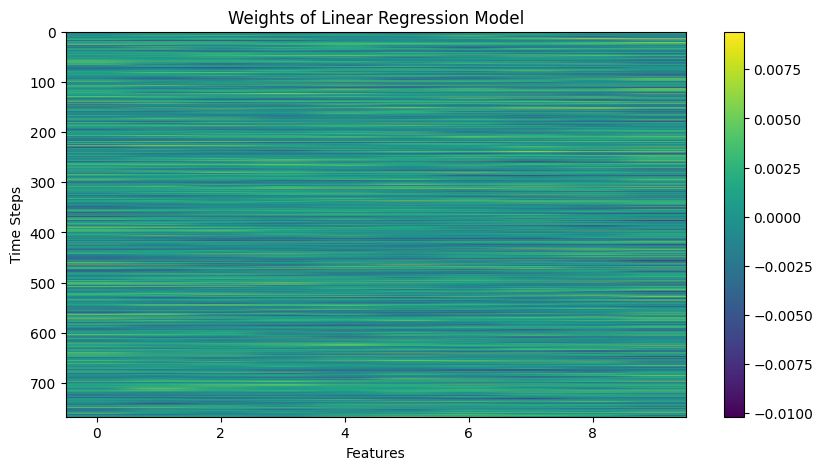

In [27]:
import matplotlib.pyplot as plt
#heatmatp for audiovisual feature learned weights
plt.figure(figsize=(10, 5))
plt.imshow(avg_weights.transpose(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Weights of Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.show()

In [28]:
# get r values of correlation
from scipy.stats import pearsonr
def calculate_r_values(predicted, activity):
    r_values = []
    for i in range(activity.shape[1]):
        r, _ = pearsonr(predicted[:, i], activity[:, i])
        r_values.append(r)
    return np.array(r_values)
predicted = model.predict(test_data)
r_values = calculate_r_values(predicted, test_activity)

/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [29]:
r_values

array([0.07963824, 0.27995333, 0.41504112, ..., 0.09081782, 0.14168593,
       0.14793675])

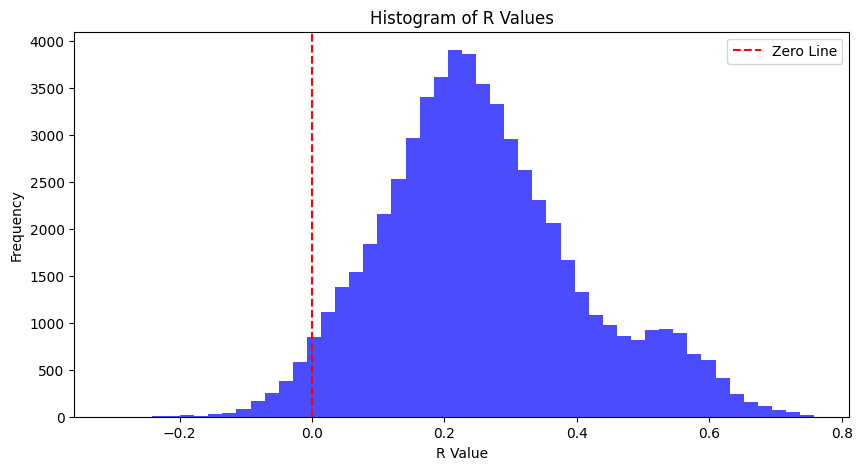

In [30]:
# plot histogram of r values
plt.figure(figsize=(10, 5))
plt.hist(r_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of R Values')
plt.xlabel('R Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.show()

In [31]:
r_LH = r_values[0:32492]
r_RH = r_values[32492:]

r_LH.shape, r_RH.shape

((32492,), (32492,))

In [32]:
import nibabel as nib
import numpy as np

data_array = nib.gifti.GiftiDataArray(np.float32(r_LH))
gifti_img = nib.gifti.GiftiImage(darrays=[data_array])
file_path = 'r_values_audioVisual.LH.func.gii'
nib.save(gifti_img, file_path)

data_array = nib.gifti.GiftiDataArray(np.float32(r_RH))
gifti_img = nib.gifti.GiftiImage(darrays=[data_array])
file_path = 'r_values_audioVisual.RH.func.gii'
nib.save(gifti_img, file_path)